In [1]:
import numpy as np
import pandas as pd

import neurodsp
from bycycle.features import compute_features
from scipy import stats
from collections import defaultdict
from operator import itemgetter
from itertools import groupby

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

# A. Autocorrelations of features

In [ ]:
# Load raw data
lfp_raw = np.load('data/ca1b.npy')
Fs_lfp = 1252

# Apply broad bandpass filter
f_theta = (4, 10)
f_bandpass = (1, 25)
filter_seconds = (2, .5)
lfp = neurodsp.filter(lfp_raw, Fs_lfp, 'highpass', f_bandpass[0],
                      N_seconds=filter_seconds[0],
                      remove_edge_artifacts=False)
lfp = neurodsp.filter(lfp, Fs_lfp, 'lowpass', f_bandpass[1],
                      N_seconds=filter_seconds[1],
                      remove_edge_artifacts=False)

In [3]:
# Compute features for each cycle
# Note need to increase N for hilbert transform function not to crash
osc_kwargs = {'amplitude_fraction_threshold':0,
              'amplitude_consistency_threshold':.6,
              'period_consistency_threshold':.75,
              'monotonicity_threshold':.8,
              'N_cycles_min':3}

df = compute_features(lfp, Fs_lfp, f_theta, center_extrema='T',
                      burst_detection_kwargs=osc_kwargs,
                      hilbert_increase_N=True)
df_cycles = df[df['is_burst']]

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [4]:
def compute_cycle_autocorr(df_shape, feat_name,
                           autocorr_delays=np.arange(1, 51),
                           corr_type = 'spearman'):
    """Compute the autocorrelation for a single feature"""

    autocorr_rs = np.zeros(len(autocorr_delays))

    # Compute time series of cycle rdsyms with nans in place for invalid
    # cycles
    max_cycle = df_shape.index.values[-1] + 1
    feat_by_cycle = np.ones(max_cycle) * np.nan
    feat_by_cycle[df_shape.index.values] = df_shape[feat_name].values

    # Compute autocorrelation
    for i, d in enumerate(autocorr_delays):
        # Determine pairs of interest for each time lag (neither NaN)
        x1 = feat_by_cycle[:-d]
        x2 = feat_by_cycle[d:]
        nan_idxs = np.logical_or(np.isnan(x1), np.isnan(x2))
        x1 = x1[~nan_idxs]
        x2 = x2[~nan_idxs]

        # Compute correlation at this delay
        if corr_type == 'spearman':
            r, _ = stats.spearmanr(x1, x2)
        elif corr_type == 'pearson':
            r, _ = stats.pearsonr(x1, x2)
        else:
            raise ValueError('invalid corr_type parameter')
        autocorr_rs[i] = r

    return autocorr_rs

# Compute autocorr for amp, period, and rdsym
feat_codes = {'volt_amp': 'amp', 'period': 'period', 'time_rdsym': 'rdsym', 'time_ptsym': 'ptsym'}
autocorr_delays = np.arange(1, 101)
autocorrs = {}
for feat_col, feat in feat_codes.items():
    autocorrs[feat] = compute_cycle_autocorr(df_cycles, feat_col, autocorr_delays=autocorr_delays)

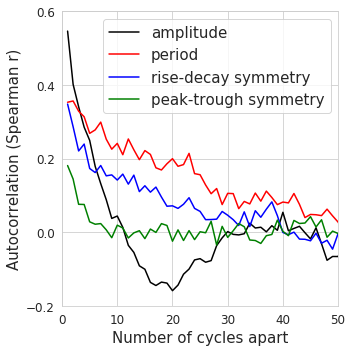

In [5]:
# Plot autocorrelations
feat_names = {'amp': 'amplitude', 'period': 'period', 'rdsym': 'rise-decay symmetry', 'ptsym': 'peak-trough symmetry'}
feat_colors = {'amp': 'k', 'period': 'r', 'rdsym': 'b', 'ptsym': 'g'}
plt.figure(figsize=(5,5))
with sns.axes_style('whitegrid'):
    for feat in autocorrs.keys():
        plt.plot(autocorr_delays, autocorrs[feat], feat_colors[feat], label=feat_names[feat])
    plt.legend(fontsize=15)
    plt.xlabel('Number of cycles apart', size=15)
    plt.ylabel('Autocorrelation (Spearman r)', size=15)
    plt.xlim((0,50))
    plt.ylim((-.2, .6))
    plt.yticks(np.arange(-.2,.8,.2), size=12)
    plt.xticks(size=12)
plt.tight_layout()
plt.savefig('figs/7A_autocorrelations_cycle_features.png')

# Correlations with previous cycles

In [6]:
osc_kw = {'amplitude_fraction_threshold':0,
          'amplitude_consistency_threshold':.6,
          'period_consistency_threshold':.75,
          'monotonicity_threshold':.8,
          'N_cycles_min':3}

# Compute features for each cycle
df = compute_features(lfp, Fs_lfp, f_theta, center_extrema='T',
                      burst_detection_kwargs=osc_kw,
                      hilbert_increase_N=True)
df_cycles = df[df['is_burst']]
cols_keep = ['is_burst', 'sample_trough'] + list(feat_codes.keys())
df_prev_cycles = df[cols_keep]

for feat in feat_codes.keys():
    # Determine feature for the previous cycle corresponding to each cycle
    for feat2 in ['is_burst'] + list(feat_codes.keys()):
        df_prev_cycles['last_'+feat2] = np.insert(df_prev_cycles[feat2].values[:-1], 0, 0)

    # Determine cycles of interest (previous cycle was also a cycle)
    df_prev_cycles = df_prev_cycles[(df_prev_cycles['is_burst']) & (df_prev_cycles['last_is_burst'])]

    # Compute correlations between feature value of current and previous cycles
    if 0 in df_prev_cycles.index:
        df_prev_cycles = df_prev_cycles.drop(0, axis=0)
    print(feat, stats.spearmanr(df_prev_cycles['last_'+feat], df_prev_cycles[feat]))

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

volt_amp SpearmanrResult(correlation=0.546460656664866, pvalue=0.0)
period SpearmanrResult(correlation=0.313333370991491, pvalue=9.370158695675236e-125)
time_rdsym SpearmanrResult(correlation=0.30234744268769653, pvalue=7.421581720244579e-116)
time_ptsym SpearmanrResult(correlation=0.147376703033929, pvalue=6.698572957729636e-28)


# B-E. Correlations between bursts

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

volt_amp SpearmanrResult(correlation=0.05646697536391018, pvalue=0.16931210625212298)
period SpearmanrResult(correlation=0.16635759398469105, pvalue=4.6139002813495523e-05)
time_rdsym SpearmanrResult(correlation=0.08758255819063278, pvalue=0.03282818560862846)
time_ptsym SpearmanrResult(correlation=-0.018713442758676365, pvalue=0.6489902983200366)


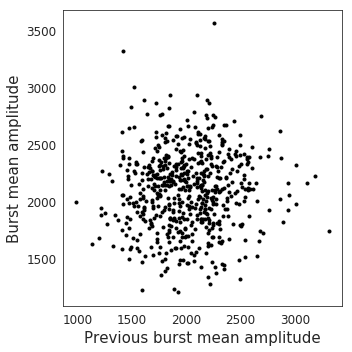

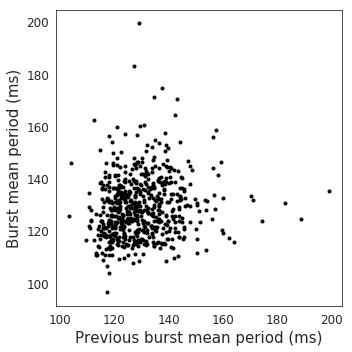

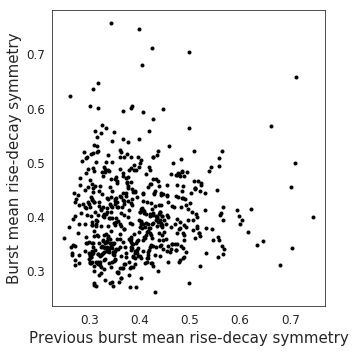

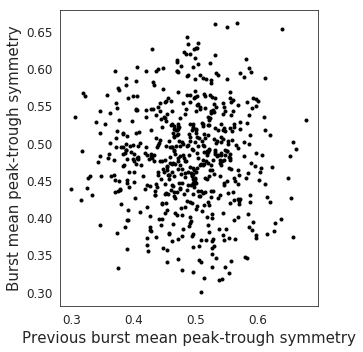

In [7]:
# Determine mean feature for each burst and the previous burst
groups = []
for k, g in groupby(enumerate(df_cycles.index), lambda x:x[0]-x[1]):
    groups.append(list(map(itemgetter(1), g)))
burst_lens = [len(x) for x in groups]
burst_lens_cycle = [burst_lens[burst_i] for burst_i in range(len(groups)) for cycle_i in groups[burst_i]]
burst_nums_cycle = [burst_i for burst_i in range(len(groups)) for cycle_i in groups[burst_i]]
df_cycles['burst_number'] = burst_nums_cycle
df_cycles['burst_len'] = burst_lens_cycle

cols_keep = list(feat_codes.keys()) + ['burst_len', 'burst_number']
df_bursts = df_cycles[cols_keep].groupby('burst_number')[list(feat_codes.keys()) + ['burst_len']].mean()
df_bursts['burst_start'] = df_cycles.groupby('burst_number')['sample_last_peak'].first()
df_bursts['burst_end'] = df_cycles.groupby('burst_number')['sample_next_peak'].last()
df_bursts['time_since_last_burst'] = np.insert(df_bursts['burst_start'].values[1:] - df_bursts['burst_end'].values[:-1], 0, 0)

for feat in feat_codes.keys():
    df_bursts['last_'+feat] = np.insert(df_bursts[feat].values[:-1], 0, 0)
df_bursts.drop(0, axis=0, inplace=True)

# Compute correlation between rdsym of this burst and rdsym of last burst
# Force bursts to be at least 1s apart in order to avoid a burst artificially split up
df_prev_burst = df_bursts[df_bursts['time_since_last_burst']>Fs_lfp]
df_prev_burst['periodms'] = df_prev_burst['period'] / Fs_lfp * 1000
df_prev_burst['last_periodms'] = df_prev_burst['last_period'] / Fs_lfp * 1000
rs_bursts = {}
ps_bursts = {}
for feat in feat_codes.keys():
    print(feat, stats.spearmanr(df_prev_burst['last_'+feat], df_prev_burst[feat]))

feat_figletter = {'volt_amp': 'B', 'periodms': 'C', 'time_rdsym': 'D', 'time_ptsym': 'E'}
feat_labels = {'volt_amp': 'amplitude', 'periodms': 'period (ms)',
               'time_rdsym': 'rise-decay symmetry', 'time_ptsym': 'peak-trough symmetry'}
for feat in feat_labels.keys():
    plt.figure(figsize=(5,5))
    plt.plot(df_prev_burst['last_'+feat], df_prev_burst[feat], 'k.')
    plt.xlabel('Previous burst mean '+feat_labels[feat], size=15)
    plt.ylabel('Burst mean '+feat_labels[feat], size=15)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.tight_layout()
    plt.savefig('figs/7{:s}_previous_burst_corr_{:s}.png'.format(feat_figletter[feat], feat))

# Control analysis of within-burst effects using Feingold's burst detection method

In [9]:
# Detect bursts with Feingold method
lfp_burst = neurodsp.detect_bursts(lfp[:3964600], Fs_lfp, f_theta, 'deviation', min_osc_periods = 2,
                                            dual_thresh = (1, 1.5))
lfp_burst = np.pad(lfp_burst, (0, 13), mode='constant', constant_values=(0,0))

# Define fraction of each cycle in burst
df = compute_features(lfp, Fs_lfp, f_theta, center_extrema='T', hilbert_increase_N=True)

feingold_burst_fracs = []
for i, row in df.iterrows():
    feingold_burst_fracs.append(np.mean(lfp_burst[int(row['sample_last_peak']):int(row['sample_next_peak']+1)]))
df['feingold_burst_fracs'] = feingold_burst_fracs

# Determine previous cycle properties
for feat in feat_codes.keys():
    df['last_'+feat] = np.insert(df[feat].values[:-1], 0, 0)
    
# Only consider cycles during a feingold burst
df_fein = df[df['feingold_burst_fracs']==1]
df_fein.reset_index(inplace=True)

# Do not consider the first cycle of a feingold burst because previous cycle not in a burst
df_fein['last_index'] = np.insert(df_fein['index'].values[:-1],0,-99)
df_fein['index_diff'] = df_fein['index'] - df_fein['last_index']
df_fein = df_fein[df_fein['index_diff']==1][['volt_amp', 'period', 'time_rdsym', 'time_ptsym',
                                             'last_volt_amp', 'last_period', 'last_time_rdsym', 'last_time_ptsym']]

# Compute correlation between previous and current cycle for feingold for each feature
for feat in feat_codes.keys():
    print(feat, stats.spearmanr(df_fein[feat], df_fein['last_'+feat]))

Transition bandwidth is 2.4 Hz. Pass/stop bandwidth is 6 Hz


/gh/bv/bycycle/bycycle/features.py:106: UserWarning: 
            No burst detection parameters are provided.
            This is very much not recommended.
            Please inspect your data and choose appropriate
            parameters for "burst_detection_kwargs".
            Default burst detection parameters are likely
            not well suited for your desired application.
            
  ''')
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarni

volt_amp SpearmanrResult(correlation=0.2971856929958935, pvalue=7.174895010816692e-82)
period SpearmanrResult(correlation=0.06353996200455837, pvalue=6.101946153805699e-05)
time_rdsym SpearmanrResult(correlation=0.4080757053065785, pvalue=2.2047765595693133e-159)
time_ptsym SpearmanrResult(correlation=0.23232279322712537, pvalue=7.34395347839271e-50)


/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
